In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import time as tm
import Sprayer_PDE as SP

import pypolo2

# Environment -- PINNS

In [2]:
Setting = pypolo2.utilities.Config()

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model
Setting.env = env_model.solve(Setting.delta_t)


100%|██████████| 2.0/2.0 [00:01<00:00,  1.80it/s]    


In [3]:
# 确定存放地址
starttime = Setting.starttime.replace(' ', '-').replace(':', '-')
Savedir = './outputs/{}/releaserate_{}'.format(Setting.strategy_name,"%03d" %(Setting.delta_t*100))
Savename = 'seed{}'.format(Setting.seed)
Setting.save_dir = Savedir
Setting.save_name = Savename
evaluator = pypolo2.experiments.Evaluator()
logger = pypolo2.experiments.Logger(None, Setting)

# Sensor

In [4]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Pilot Survey

In [5]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 0 in random, numpy, and torch.


# Set initual data

In [6]:
# 初始化污染源
if Setting.randomsource == True:
    # gengerate two set of random numbers for source locations
    numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
    pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
    for i in range(Setting.sourcenum):
        number = rng.randint(150, 300, size=1)
        Setting.RR[i,0] = int(pairs[i,0])
        Setting.RR[i,1] = int(pairs[i,1])
        Setting.RR[i,2] = number

print(Setting.RR)
#  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
s = 1
Setting.R =  -6 * np.ones((Setting.grid_x, Setting.grid_y)) + 13 * np.random.random((Setting.grid_x, Setting.grid_y))
for i in range(Setting.sourcenum):
        Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
        
env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model

y_init = np.zeros((Setting.num_init_samples,1))
y_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))
time_init = np.zeros((Setting.num_init_samples,1))
time_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))

#固定站的观测的观测
for time in range(Setting.time_before_sche):
    # y_stations[Setting.station_size*time:Setting.station_size*(time+1)] = sensor.sense(states=Setting.x_station, rng=rng).reshape(-1, 1)
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*Setting.time_co
    time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*1
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-10+1)*Setting.time_co
    Setting.env = env_model.solve((time+1)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
#假设每次观测后均变化时间，环境也随之发生变化
for time in range(Setting.num_init_samples):
    y_init[time] = sensor.sense(states=Setting.x_init[time], rng=rng).reshape(-1, 1)
    if time == 0:
        y_stations[:] = y_init[time] - 20
    # time_init[time] = (time+1)*Setting.time_co
    time_init[time] = (time+1)*1
    Setting.env = env_model.solve((1+Setting.time_before_sche+time)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
Setting.x_init = np.hstack((Setting.x_init,time_init))

Setting.x_stations = Setting.x_station
for i in range(Setting.time_before_sche-1):
    Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.hstack((Setting.x_stations,time_stations))

Setting.x_init = np.vstack((Setting.x_stations,Setting.x_init))
y_init = np.vstack((y_stations,y_init))

[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 4.0/4.0 [00:00<00:00,  8.39it/s]    
100%|██████████| 6.0/6.0 [00:00<00:00,  9.07it/s]    
100%|██████████| 8.0/8.0 [00:00<00:00,  9.74it/s]    
100%|██████████| 10.0/10.0 [00:01<00:00,  8.53it/s]   
100%|██████████| 12.0/12.0 [00:01<00:00,  8.83it/s]   


# Model

In [7]:
Setting.time_stamp = Setting.x_init[:,2].max(axis=0, keepdims=False)

In [8]:
kernel = pypolo2.kernels.RBF(Setting)

In [9]:
model = pypolo2.models.GPR(
    x_train=Setting.x_init,
    y_train=y_init,
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [10]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 05 loss:  8.64: 100%|██████████| 6/6 [00:00<00:00, 111.41it/s]


# Robot

In [11]:
vehicle_team = dict()
for i in range(Setting.team_size):
    robot = pypolo2.robots.SPRINKLER_REPLENISHANYWHERE(
        init_state = np.array([Setting.x_init[-1, 0], Setting.x_init[-1, 1]]),
        Setting = Setting
    )
    vehicle_team[i+1] = robot #因此team的id从1开始

# Strategy

In [12]:
strategy = pypolo2.strategies.SALatticePlanningMISprinklerControl_mimethod2(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )
Setting.strategy = strategy

# Experiment

In [13]:
#定义需要随时间更新的训练过程
def run(rng, model, Setting, sensor, evaluator, logger, vehicle_team) -> None:
    current_step = 0 #总规划长度
    adaptive_step = Setting.adaptive_step #自适应长度
    # change_step = Setting.R_change_interval - 0*Setting.adaptive_step # 污染源变化间隔
    change_step = 0
    spray_effect = 0 # 洒水效果
    result, MI_information, observed_env, computed_effect = None, None, None, None
    while current_step < Setting.max_num_samples:
        # 计算用于显示的信息量，目标估计，洒水效果
        allpoint_list = []
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                allpoint_list.append([i, j, model.time_stamp])
        allpoint = np.array(allpoint_list)
        mean, _ = model(allpoint)
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, mean, Setting.task_extent).ravel()
        prior_diag_std, poste_diag_std, _, _ = model.prior_poste(allpoint)
        hprior = pypolo2.objectives.entropy.gaussian_entropy(prior_diag_std.ravel())
        hposterior = pypolo2.objectives.entropy.gaussian_entropy(poste_diag_std.ravel())
        mi_all = hprior - hposterior
        if np.any(mi_all < 0.0):
            print(mi_all.ravel())
            raise ValueError("Predictive MI < 0.0!")
        MI_information = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        observed_env = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        computed_effect = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                MI_information[i,j] = mi_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                observed_env[i,j] = mean[i*(Setting.task_extent[3]-Setting.task_extent[2])+j,0]
                computed_effect[i,j] = sprayeffect_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                
        Setting.current_step = current_step
        # scheduling and update agent goals 计算搜索时间
        if adaptive_step >= Setting.adaptive_step:
            start = tm.time()
            result = strategy.get(model = model, Setting = Setting, pred = observed_env)
            adaptive_step = 0
            for id, vehicle in vehicle_team.items():
                vehicle.set_goals(result[id][0],result[id][1])
            end = tm.time()
            print('search_time')
            print(end-start)    
            
        # calculate metrix and save 
        coverage, mean_airpollution, max_airpollution = evaluator.eval_results(Setting.env, Setting.task_extent, vehicle_team)
        logger.append(current_step, Setting.env, observed_env, MI_information, computed_effect, vehicle_team, coverage, mean_airpollution, max_airpollution, spray_effect)
           
        # change source,每经过R_change_interval后，改变源分布和强度，
        if change_step >= Setting.R_change_interval:
            change_step = 0
            if Setting.randomsource == True:
                # gengerate two set of random numbers for source locations
                numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
                pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
                for i in range(Setting.sourcenum):
                    number = rng.randint(150, 300, size=1)
                    Setting.RR[i,0] = int(pairs[i,0])
                    Setting.RR[i,1] = int(pairs[i,1])
                    Setting.RR[i,2] = number

        print(Setting.RR)
        #  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
        s = 1
        # if change_step == 0:
        #     s = 0.2
        if change_step == 0 or change_step == Setting.R_change_interval - 1:
            s = 0.5
        Setting.R =  -6 * np.ones((Setting.grid_x, Setting.grid_y)) + 13 * np.random.random((Setting.grid_x, Setting.grid_y))
        for i in range(Setting.sourcenum):
             Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
             
        # 计算如果没有更新洒水时的环境变化
        env_model1 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = Setting.current_step * Setting.delta_t) # build model
        env_withoutspray = env_model1.solve(Setting.delta_t)
        # update state 并将车辆的轨迹和洒水轨迹取出来
        x_new = []
        y_new = []
        for id, vehicle in vehicle_team.items():
            vehicle.update()
            current_state = vehicle.state.copy().reshape(1, -1)
            x_new.append(current_state)
            y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
            if Setting.current_step == 0:
                Setting.data_sprayer_train.append(pd.DataFrame())
            else:
                if vehicle.spray_flag == True:
                    new_pd = pd.DataFrame({"time":(Setting.current_step + 1) * Setting.delta_t, "x":current_state[0,0],\
                                            "y":current_state[0,1], "spray_volume":500},index=[0])
                    # Setting.data_sprayer_train[id-1] = Setting.data_sprayer_train[id-1].append(new_pd, ignore_index=True)
                    Setting.data_sprayer_train[id-1] = pd.concat([Setting.data_sprayer_train[id-1],new_pd])
        # 计算带入洒水后的环境情况
        env_model2 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = Setting.current_step * Setting.delta_t) # build model
        Setting.env = env_model2.solve(Setting.delta_t)
        sensor.set_env(Setting.env)
        # 计算洒水效果
        spray_effect = np.sum(env_withoutspray - Setting.env)
            
        # using new data to update gpr model
        x_new = np.concatenate(x_new, axis=0)
        y_new = np.concatenate(y_new, axis=0)
        #add time dim
        model.time_stamp = model.time_stamp + Setting.time_co
        Setting.time_stamp = model.time_stamp
        model_input = np.zeros((x_new.shape[0],3))
        model_input[:,0:2] = x_new
        model_input[:,2:3] = model.time_stamp
        #optimize model
        model.add_data(model_input, y_new)
        model.optimize(num_iter=len(y_new), verbose=False)
        
        adaptive_step = adaptive_step + 1    
        current_step = current_step + 1
        change_step = change_step + 1  
    return 0

In [14]:
start = tm.time()
Setting.strategy = strategy
run(rng, model, Setting, sensor, evaluator, logger, vehicle_team)
# pypolo2.experiments.utilities.print_metrics(logger, Setting.max_num_samples-1)
end = tm.time()
# logger.save(end-start)  # I temporarily removed "makefile()".

current_turn
1.0
sche_step
18
mi_high
8.045053165393705
sprayeffectarv
[0.06860167 0.06160279 0.07353838 0.07241315 0.07156653]
CurrentInfo
0.8110791820349732
object_mi
[12.06757975 12.06757975 12.06757975 12.06757975 12.06757975]
enough_info
[False False False False False]
single_playout
176.0
search_time
192.6484591960907
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.41it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.46it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.77it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.28it/s]    


current_turn
2.0
sche_step
18
mi_high
14.561016190468768
sprayeffectarv
[0.09636252 0.11364415 0.0687599  0.08841491 0.11199119]
CurrentInfo
3.9219247072593864
object_mi
[21.84152429 21.84152429 21.84152429 21.84152429 21.84152429]
enough_info
[False False False False False]
single_playout
115.0
search_time
159.56270575523376
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.07it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.12it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.15it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.60it/s]    


current_turn
3.0
sche_step
18
mi_high
19.59021456523021
sprayeffectarv
[4.79457708 4.8447809  0.06988716 1.8591601  0.09050672]
CurrentInfo
8.79578834791372
object_mi
[29.38532185 29.38532185 29.38532185 29.38532185 29.38532185]
enough_info
[False False False False False]
single_playout
96.0
search_time
143.03635692596436
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.92it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.02it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.00it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.04it/s]    


current_turn
4.0
sche_step
18
mi_high
27.489871848167855
sprayeffectarv
[ 1.3499666  26.64007486  0.07307961  0.07310004  0.09892345]
CurrentInfo
15.596378363797076
object_mi
[41.23480777 26.94007441 41.23480777 41.23480777 41.23480777]
enough_info
[False  True False False False]
single_playout
87.0
search_time
146.08154726028442
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.90it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.90it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.89it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.84it/s]    


current_turn
5.0
sche_step
18
mi_high
31.664877901066998
sprayeffectarv
[ 6.55696393 83.72901974  0.07192349  0.07638829  0.10053389]
CurrentInfo
23.44907888047721
object_mi
[47.49731685 28.49839011 47.49731685 47.49731685 47.49731685]
enough_info
[False  True False False False]
single_playout
81.0
search_time
134.86051440238953
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.76it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.89it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.94it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.99it/s]    


current_turn
6.0
sche_step
18
mi_high
43.00361231988592
sprayeffectarv
[ 11.54746383 164.7089122    0.07838971   0.07603309   0.7944948 ]
CurrentInfo
31.044073825326386
object_mi
[40.42339558 38.70325109 64.50541848 64.50541848 64.50541848]
enough_info
[ True  True False False False]
single_playout
78.0
search_time
137.28209900856018
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.45it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.15it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.15it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.09it/s]    


current_turn
7.0
sche_step
18
mi_high
48.66108457688938
sprayeffectarv
[  5.46920124 123.64878312   0.0816269    0.06566476   4.73958873]
CurrentInfo
38.95783437640665
object_mi
[72.99162687 43.79497612 72.99162687 72.99162687 72.99162687]
enough_info
[False  True False False False]
single_playout
75.0
search_time
126.88492155075073
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.87it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.95it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.50it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.97it/s]    


current_turn
8.0
sche_step
18
mi_high
57.86460628612213
sprayeffectarv
[ 75.06926899 212.68509372   0.07673788   0.06029405   5.49780534]
CurrentInfo
47.46582324759838
object_mi
[54.39272991 43.39845471 86.79690943 86.79690943 86.79690943]
enough_info
[ True  True False False False]
single_playout
73.0
search_time
138.30916905403137
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.84it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.92it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.79it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.44it/s]    


current_turn
9.0
sche_step
18
mi_high
64.95802203623343
sprayeffectarv
[135.72743589 161.79388038   0.08203979   0.0653739   71.6438183 ]
CurrentInfo
58.1195433704745
object_mi
[58.46221983 58.46221983 97.43703305 97.43703305 58.46221983]
enough_info
[ True  True False False  True]
single_playout
72.0
search_time
137.2841362953186
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.90it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.06it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.47it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.30it/s]    


current_turn
10.0
sche_step
18
mi_high
72.91743206075967
sprayeffectarv
[135.14302197 205.77446245   0.10501718   0.07621719 125.18259676]
CurrentInfo
67.03826991161792
object_mi
[62.70899157 54.68807405 70.00073478 70.00073478 62.70899157]
enough_info
[ True  True  True  True  True]
single_playout
71.0
search_time
152.86320877075195
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.79it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.78it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.70it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.69it/s]    


current_turn
11.0
sche_step
18
mi_high
80.50761469333857
sprayeffectarv
[185.50002873 232.52714524   0.09770542   0.09287223 108.37555126]
CurrentInfo
74.9408713919494
object_mi
[60.38071102 60.38071102 77.28731011 77.28731011 66.01624405]
enough_info
[ True  True  True  True  True]
single_playout
70.0
search_time
132.5851285457611
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.00it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.91it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.85it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.99it/s]    


current_turn
12.0
sche_step
18
mi_high
88.12332958594462
sprayeffectarv
[175.8671699  256.25846771   0.09431979   0.09763267 150.81312972]
CurrentInfo
81.86785723273277
object_mi
[75.78606344 66.09249719 84.5983964  84.5983964  75.78606344]
enough_info
[ True  True  True  True  True]
single_playout
69.0
search_time
138.6123926639557
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.82it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.26it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.87it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.94it/s]    


current_turn
13.0
sche_step
18
mi_high
93.07442587329217
sprayeffectarv
[198.21080571 198.94583434   0.09598078   4.44366873 212.64654394]
CurrentInfo
88.06962511618076
object_mi
[69.8058194  69.8058194  89.35144884 89.35144884 69.8058194 ]
enough_info
[ True  True  True  True  True]
single_playout
68.0
search_time
139.12316131591797
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.23it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.84it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.10it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.27it/s]    


current_turn
14.0
sche_step
18
mi_high
99.5265862205883
sprayeffectarv
[217.47112588 228.13706437  10.45597889  15.76420469 167.70394511]
CurrentInfo
93.967299374413
object_mi
[74.64493967 74.64493967 85.59286415 85.59286415 81.6118007 ]
enough_info
[ True  True  True  True  True]
single_playout
68.0
search_time
138.93293619155884
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.81it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.79it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.38it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.74it/s]    


current_turn
15.0
sche_step
18
mi_high
102.69483095715674
sprayeffectarv
[250.6276978  233.12191457   4.53731776   5.45420712 122.10485978]
CurrentInfo
98.28158422925986
object_mi
[77.02112322 77.02112322 98.58703772 98.58703772 84.20976138]
enough_info
[ True  True  True  True  True]
single_playout
67.0
search_time
137.7490360736847
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.06it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.98it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.84it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.57it/s]    


current_turn
16.0
sche_step
18
mi_high
105.53978094061797
sprayeffectarv
[218.24709657 234.43164421   4.09567535  52.13942614 131.70658258]
CurrentInfo
101.8951663785024
object_mi
[79.15483571 79.15483571 98.15199627 90.76421161 86.54262037]
enough_info
[ True  True  True  True  True]
single_playout
67.0
search_time
154.270663022995
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.66it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.63it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.55it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.60it/s]    


current_turn
17.0
sche_step
18
mi_high
109.63969392174921
sprayeffectarv
[238.42472597 215.27637677   6.09415195  18.4662215  114.72779746]
CurrentInfo
105.07214028959221
object_mi
[ 82.22977044  82.22977044 101.96491535  94.29013677  89.90454902]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
143.97264075279236
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.60it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.64it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.61it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.62it/s]    


current_turn
18.0
sche_step
16
mi_high
111.47332780308307
sprayeffectarv
[209.15570119 169.03996053  84.836115    19.21144456 159.433881  ]
CurrentInfo
108.1265686963382
object_mi
[83.60499585 95.86706191 95.86706191 91.4081288  95.86706191]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
142.264057636261
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.61it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.47it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.56it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.59it/s]    


current_turn
19.0
sche_step
14
mi_high
111.9384533504297
sprayeffectarv
[250.98360484 134.43245413  55.36062184  90.49326663 149.44292639]
CurrentInfo
110.88117666859958
object_mi
[83.95384001 96.26706988 91.78953175 96.26706988 96.26706988]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
140.84743928909302
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.90it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.81it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.94it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.86it/s]    


current_turn
20.0
sche_step
12
mi_high
112.5524275280071
sprayeffectarv
[251.01550076 177.53308369 116.24349753 165.43810738 158.26499339]
CurrentInfo
113.02181358741888
object_mi
[84.41432065 96.79508767 96.79508767 96.79508767 96.79508767]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
131.85732626914978
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.49it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.88it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.82it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.85it/s]    


current_turn
21.0
sche_step
10
mi_high
110.48145968738271
sprayeffectarv
[272.0004969  222.48226599 160.50113839 167.92540727 201.59812796]
CurrentInfo
114.25554201444135
object_mi
[82.86109477 82.86109477 86.17553856 86.17553856 82.86109477]
enough_info
[ True  True  True  True  True]
single_playout
65.0
search_time
113.92524600028992
[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.57it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.56it/s]    


[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.18it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.02it/s]    


current_turn
22.0
sche_step
8
mi_high
114.25217179049844
sprayeffectarv
[175.53137765 230.77554727 170.68583719 160.92644222 119.45330055]
CurrentInfo
115.01239276288997
object_mi
[98.25686774 85.68912884 98.25686774 98.25686774 98.25686774]
enough_info
[ True  True  True  True  True]
single_playout
65.0
search_time
82.1729667186737
[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.64it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.64it/s]    


[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.70it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.33it/s]    


current_turn
23.0
sche_step
8
mi_high
113.18851755342966
sprayeffectarv
[176.08668288 147.50371735 171.1851668  142.83309543 125.76711449]
CurrentInfo
114.55907489478956
object_mi
[101.8696658 101.8696658 101.8696658 101.8696658 101.8696658]
enough_info
[ True  True  True  True  True]
single_playout
65.0
search_time
80.0042073726654
[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.69it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.60it/s]    


[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.73it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.62it/s]    


current_turn
24.0
sche_step
8
mi_high
113.87930442897138
sprayeffectarv
[174.1006684  139.2920254   91.90349756 102.45850357  95.99987107]
CurrentInfo
113.25872727668337
object_mi
[102.49137399 102.49137399 102.49137399 102.49137399 102.49137399]
enough_info
[ True  True  True  True  True]
single_playout
65.0
search_time
86.42101335525513
[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.20it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.74it/s]    


[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.06it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.98it/s]    


current_turn
25.0
sche_step
8
mi_high
112.10592674274724
sprayeffectarv
[108.57572519 122.00523005 107.09930165  74.60958596 118.73330716]
CurrentInfo
110.91740239312192
object_mi
[100.89533407 100.89533407 100.89533407  91.92685993 100.89533407]
enough_info
[ True  True  True  True  True]
single_playout
65.0
search_time
91.9360363483429
[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.05it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.15it/s]    


[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.08it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.08it/s]    


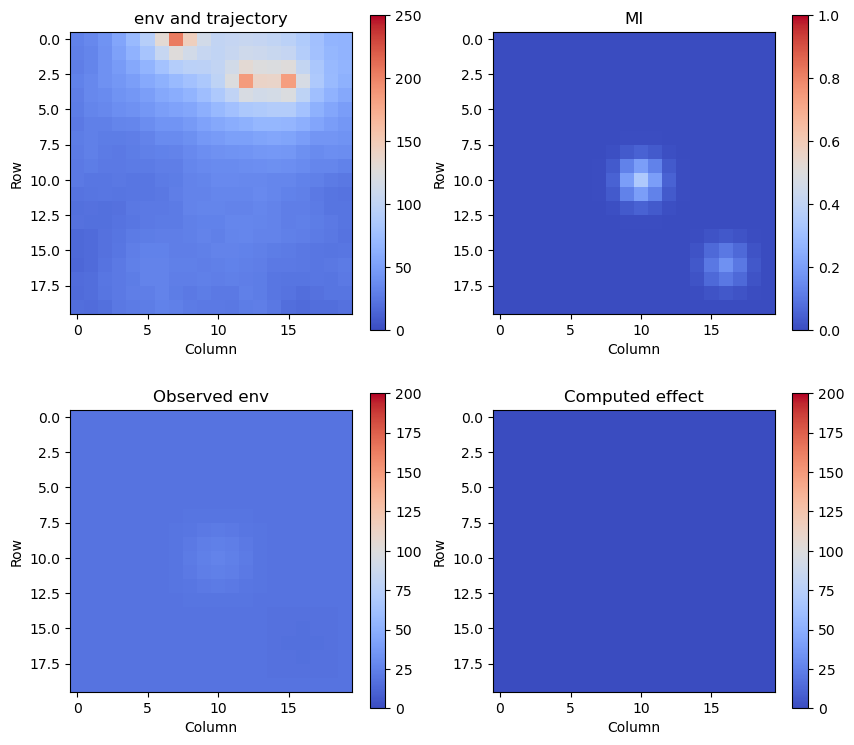

In [15]:
from pypolo2.experiments import visualizer
ani = visualizer.visual(logger)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

In [16]:
import math
import numpy as np
Temp = 1
k = math.pow(0.00002, 1 / 10)
k = math.pow(k, 3)
delta_e_2 = -0.1
accept_prob = np.exp(delta_e_2 / (k * Temp))
print(k)
print(accept_prob)

0.03893220474761734
0.07664525292497093


In [17]:
numbers = rng.randint(0, 19, size=10)
pairs = rng.choice(numbers, size=(5, 2), replace=False)
print(pairs)

[[14  7]
 [ 0 11]
 [ 6  8]
 [ 9 10]
 [ 5  8]]


In [18]:
Setting.RR

array([[ 16,  10, 188],
       [  3,  10, 286],
       [ 17,  16, 163]])